<a href="https://colab.research.google.com/github/erendagstan/RNN_AirlinePassengerNumber/blob/main/RNN_AirlinePassengerNumberForecastModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# importing libraries
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [107]:
df = pd.read_csv('/content/sample_data/international-airline-passengers.csv')

# Data Understanding

In [108]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [109]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [110]:
df.columns = ['Month','Passengers']

In [111]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [112]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [113]:
df.shape

(145, 2)

In [114]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [115]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [116]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


# Data Preparation

In [117]:
df = df[:144]

In [118]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [120]:
df['Month'] = pd.to_datetime(df['Month'])

In [121]:
print('Max Date:', df['Month'].max())
print('Min Date:', df['Month'].min())

Max Date: 1960-12-01 00:00:00
Min Date: 1949-01-01 00:00:00


In [122]:
df.index = df['Month']

In [123]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [124]:
df.drop('Month',axis=1,inplace=True)

In [125]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [126]:
result_df = df.copy()

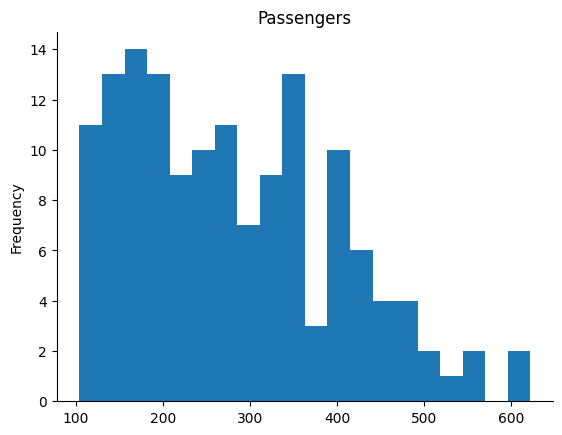

In [127]:
# @title Passengers

from matplotlib import pyplot as plt
df['Passengers'].plot(kind='hist', bins=20, title='Passengers')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: title={'center': 'Monthly Airline Passengers'}, xlabel='Month'>

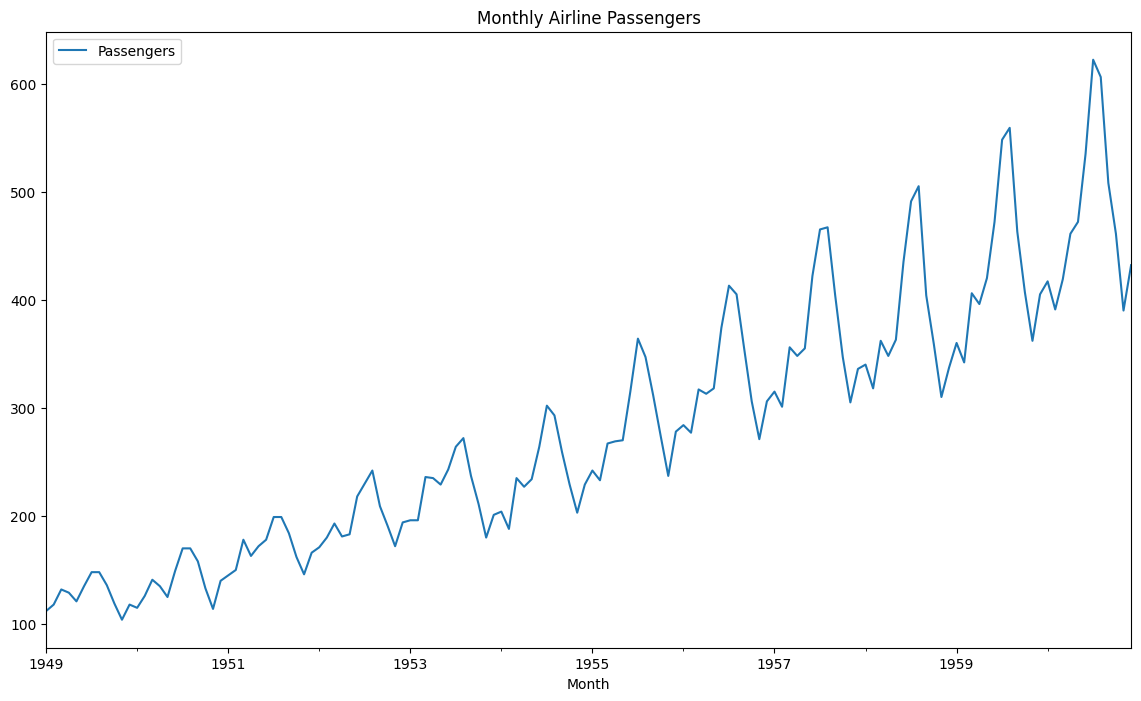

In [128]:
df.plot(figsize=(14,8), title='Monthly Airline Passengers')

In [129]:
data = df['Passengers'].values

In [130]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [131]:
type(data[0])

numpy.float64

In [132]:
data = data.astype('float32')
print(type(data[0]))

<class 'numpy.float32'>


In [133]:
data.shape

(144,)

In [134]:
data = data.reshape(-1,1)
data.shape

(144, 1)

In [135]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [136]:
train, test, position = split_data(data, 0.33) # train % 77 - test % 33

In [137]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [138]:
scaler_train = MinMaxScaler(feature_range = (0,1)) # to prevent data leakage

In [139]:
train = scaler_train.fit_transform(train)

In [140]:
scaler_test = MinMaxScaler(feature_range = (0,1)) # to prevent data leakage

In [141]:
test = scaler_test.fit_transform(test)

In [142]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [143]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [144]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [145]:
lookback = 1

In [146]:
X_train, y_train = create_features(train,lookback)

In [147]:
X_test, y_test = create_features(test,lookback)

In [148]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [149]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [150]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # prepare data for RNN model (3 canal)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


# Modeling

In [151]:
model = Sequential()

model.add(SimpleRNN(units = 50,
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback)))

model.add(Dropout(0.2))
model.add(Dense(1)) # 1 because the target is regression

In [152]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [153]:
# setting optimization and evaluation metrics

model.compile(loss = 'mean_squared_error', optimizer = 'adam') #adam ~ scd/rms-prompt/...

In [154]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose =1, mode='min'), # if the success in the validation set stops/decreases after a certain iteration, it stops.
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', # saving model
                             save_best_only=True, save_weights_only=False, verbose=1)]

In [155]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs = 50,
                    batch_size=1,
                    validation_data=(X_test,y_test),
                    callbacks = callbacks,
                    shuffle = False)

Epoch 1/50
81/95 [========================>.....] - ETA: 0s - loss: 0.0068
Epoch 1: val_loss improved from inf to 0.03047, saving model to mymodel.h5
95/95 [==============================] - 2s 6ms/step - loss: 0.0087 - val_loss: 0.0305
Epoch 2/50
93/95 [============================>.] - ETA: 0s - loss: 0.0146
Epoch 2: val_loss improved from 0.03047 to 0.02306, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0147 - val_loss: 0.0231
Epoch 3/50
86/95 [==========================>...] - ETA: 0s - loss: 0.0101
Epoch 3: val_loss did not improve from 0.02306
95/95 [==============================] - 0s 3ms/step - loss: 0.0117 - val_loss: 0.0241
Epoch 4/50
86/95 [==========================>...] - ETA: 0s - loss: 0.0074
Epoch 4: val_loss improved from 0.02306 to 0.02061, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0206
Epoch 5/50
76/95 [=======================>......] - ETA: 0s - loss: 0.00

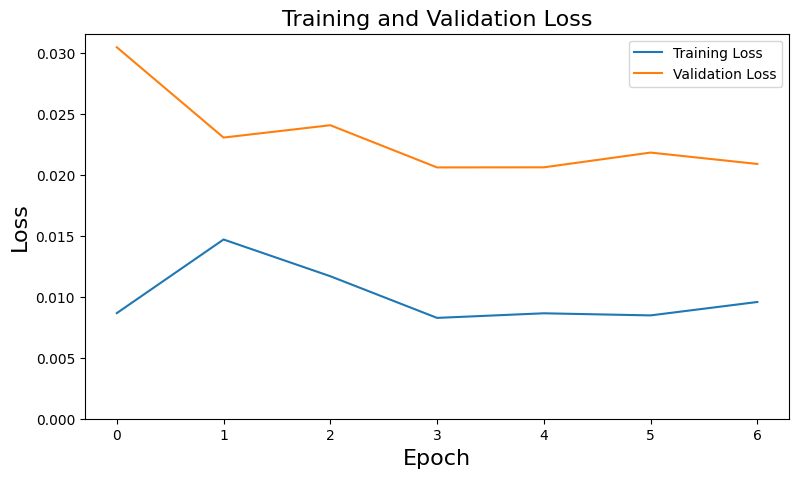

In [156]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()


# Evaluation

In [157]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print('\nTest loss: %.1f%%' % (100.0 * loss))

47/47 [==============================] - 0s 2ms/step - loss: 0.0209

Test loss: 2.1%


In [158]:
train_predict = model.predict(X_train)

3/3 [==============================] - 0s 4ms/step


In [159]:
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [160]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [161]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [162]:
# Train RMSE
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))

In [163]:
# Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [164]:
print('\nTrain RMSE: %.5f%%' %train_rmse)
print('\nTest RMSE: %.5f%%' %test_rmse)


Train RMSE: 23.13170%

Test RMSE: 46.40104%


In [165]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [166]:
train_prediction_df = result_df[lookback:position]

In [167]:
train_prediction_df["Predicted"] = train_predict

In [168]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,128.088364
1949-03-01,132.0,131.654160
1949-04-01,129.0,143.308945
1949-05-01,121.0,140.512161
1949-06-01,135.0,133.672501


In [169]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,329.379333
1957-03-01,356.0,322.156067
1957-04-01,348.0,365.992767
1957-05-01,355.0,358.534698
1957-06-01,422.0,365.060547


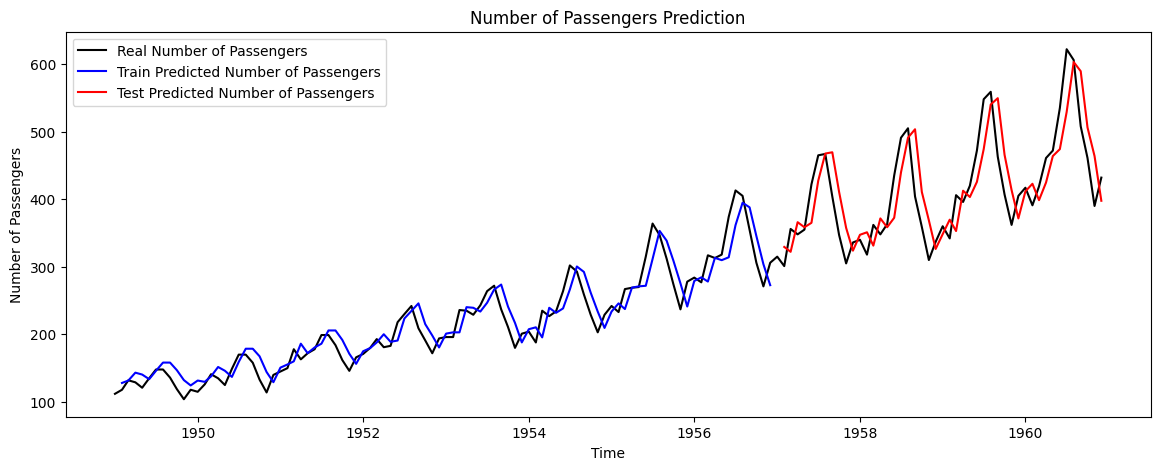

In [173]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label='Real Number of Passengers', color='black')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color='red', label='Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()